# Chatbot with message summarization

In [25]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [26]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [27]:
from langchain_groq import ChatGroq
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"),temperature=0)

In [44]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [45]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [46]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [47]:
from langgraph.graph import END
def should_continue(state: State):
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

# Adding Memory

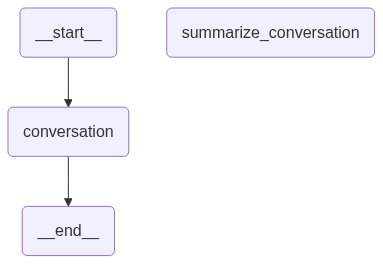

In [53]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Define the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Add edges
workflow.add_edge(START, "conversation")  # Entry point
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)  # Summary flows to end

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# Threads

![threads](https://camo.githubusercontent.com/bfdbe4fa22998efcc4642f63bef062f1082a413b1f5ecbb2062ce708dc1df82f/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261646633623337396332656536323161646664315f63686174626f742d73756d6d6172697a6174696f6e312e706e67)

In [49]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Pandhari")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Pandhari, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

Your name is Pandhari.
================================== Ai Message ==================================

A football fan, I see. The San Francisco 49ers have a rich history in the NFL. Who's your favorite player, past or present? Jerry Rice, Joe Montana, or maybe someone from the current roster like George Kittle or Deebo Samuel?


In [50]:
graph.get_state(config).values.get("summary","")

''

In [51]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is an excellent choice. He's a talented defensive end and a key player for the 49ers. As for being the highest-paid defensive player, that's close, but not quite. Nick Bosa did sign a massive contract extension with the 49ers in 2023, but I think Aaron Donald of the Los Angeles Rams currently holds the title of highest-paid defensive player in the NFL. Nonetheless, Bosa's contract is certainly one of the most lucrative for a defensive player, and he's definitely worth every penny given his impressive performance on the field.


In [52]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\n* You introduced yourself as Pandhari.\n* I acknowledged your introduction and offered to help or chat.\n* You mentioned that you like the San Francisco 49ers football team.\n* We discussed your favorite player, Nick Bosa, and his contract, noting that while he's one of the highest-paid defensive players, Aaron Donald currently holds the title of highest-paid defensive player in the NFL."